In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))

library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/paths/paths.R")
source("src/load/load.R")


Linking to GEOS 3.12.0, GDAL 3.7.3, PROJ 9.3.0; sf_use_s2() is TRUE

terra 1.7.55



In [2]:
scia <- open_dataset(file.path(path.ds, "SCIA", "giornaliere", "python_dataset"), partition)

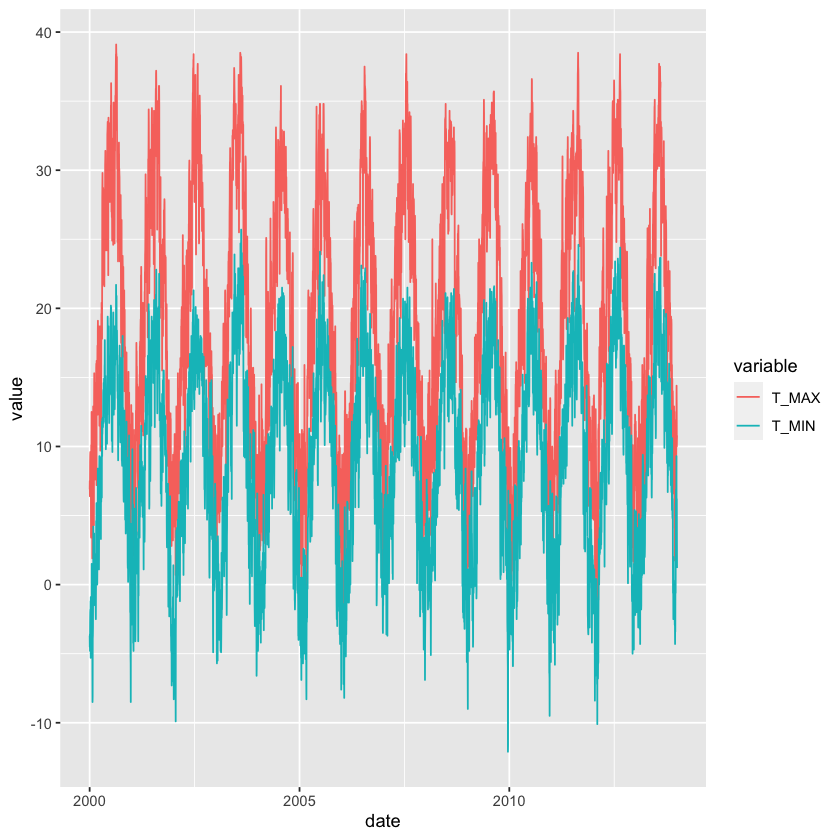

In [16]:
library(ggplot2)
scia |> filter(identifier == 8083) |> arrange(date) |> collect() |> ggplot() + geom_line(aes(date, value, color = variable))

In [3]:
tvar <- "T_MAX"
scia <- load.series("SCIA", tvar)


Cache found: SCIA/T_MAX, suffix: <>, loading from disk



In [6]:
if (!dir.exists(file.path("scia_split", tvar))) dir.create(file.path("scia_split", tvar), recursive = TRUE)
scia |>
    group_by_key() |>
    group_walk(~ write_parquet(. |> drop_na(), file.path("scia_split", tvar, paste0(.y[[1]], ".parquet"))))


In [4]:
ds_tmax <- read_parquet(ls.SCIA.datafiles("T_MAX"), as_data_frame = FALSE) |>
    mutate(variable = "T_MAX", value = cast(`Temperatura massima `, float32()), .keep = "unused")
ds_tmin <- read_parquet(ls.SCIA.datafiles("T_MIN"), as_data_frame = FALSE) |>
    mutate(variable = "T_MIN", value = cast(`Temperatura minima `, float32()), .keep = "unused")


In [5]:
all_data <- concat_tables(ds_tmax |> as_arrow_table(), ds_tmin |> as_arrow_table()) |>
    mutate(identifier = cast(internal_id, int32()), .keep = "unused") |> collect()


In [6]:
all_data


date,variable,value,identifier
<date>,<chr>,<dbl>,<int>
1996-10-11,T_MAX,3.8,5630
1996-10-12,T_MAX,4.3,5630
1996-10-13,T_MAX,0.4,5630
1996-10-14,T_MAX,0.1,5630
1996-10-15,T_MAX,4.9,5630
1996-10-16,T_MAX,0.9,5630
1996-10-17,T_MAX,-0.4,5630
1996-10-18,T_MAX,2.1,5630
1996-10-19,T_MAX,1.7,5630


In [11]:
write_mkdir <- function(data, fname) {
    dir.create(dirname(fname), recursive = TRUE)
    write_parquet(data, fname)
}


In [7]:
all_data |>
    arrange(variable, identifier, date) |>
    group_by(variable, identifier) |>
    as_arrow_table(schema = schema(date = date32(), variable = utf8(), value = float32(), identifier = int32())) |>
    write_dataset(file.path(path.ds, "SCIA", "dataset1"), max_open_files = 20L, min_rows_per_group = 10000L)


In [9]:
all_data |>
    collect() |>
    group_by(variable, identifier) |>
    group_walk(
        ~ write_mkdir(
            . |> drop_na() |> add_column(identifier = .y[[2]], variable = .y[[1]]) |> as_arrow_table(schema = schema(date = date32(), value = float32(), identifier = int32(), variable = utf8())) |> mutate(identifier = cast(identifier, uint32())),
            file.path(
                path.ds,
                "SCIA",
                "dataset",
                paste0("variable=", .y[[1]]),
                paste0("identifier=", .y[[2]]),
                "part-0.parquet"
            )
        )
    )
